In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")

print("Path to dataset files:", path)

100%|██████████| 154M/154M [00:04<00:00, 36.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ankit1743/skyview-an-aerial-landscape-dataset/versions/1


In [ ]:
!pip install kagglehub


In [ ]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kandukurisrinidhi","key":"06edd0580d7a5615b398816954187a6a"}'}

In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/skyview-an-aerial-landscape-dataset


In [ ]:
import shutil
import os

# Define the dataset path after downloading
dataset_path = "/kaggle/input/skyview-an-aerial-landscape-dataset"

# Define the destination path
destination_path = "/content/intel-aerial-classification"

# Check if dataset exists and copy
if os.path.exists(dataset_path):
    shutil.copytree(dataset_path, destination_path, dirs_exist_ok=True)
    print("Dataset copied successfully to:", destination_path)
    print("Files in the dataset folder:", os.listdir(destination_path))
else:
    print("Dataset not found at:", dataset_path)

# Check the contents of the dataset folder
print("Dataset files:", os.listdir(dataset_path))


Dataset copied successfully to: /content/intel-aerial-classification
Files in the dataset folder: ['Aerial_Landscapes']
Dataset files: ['Aerial_Landscapes']


In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set paths
base_dir = '/content/intel-aerial-classification'
source_dir = os.path.join(base_dir, 'Aerial_Landscapes')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Create target folders
for category in os.listdir(source_dir):
    category_path = os.path.join(source_dir, category)
    if os.path.isdir(category_path):
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        # List all images
        images = os.listdir(category_path)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Move files
        for img in train_images:
            src = os.path.join(category_path, img)
            dst = os.path.join(train_dir, category, img)
            shutil.copy2(src, dst)

        for img in test_images:
            src = os.path.join(category_path, img)
            dst = os.path.join(test_dir, category, img)
            shutil.copy2(src, dst)

print("Data split complete!")


Data split complete!


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Paths
base_path = '/content/intel-aerial-classification'  # update this!
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

# Train/Validation loaders
train_loader = train_gen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_loader = train_gen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_loader = test_gen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 7680 images belonging to 15 classes.
Found 1920 images belonging to 15 classes.
Found 2400 images belonging to 15 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load MobileNetV2
base_model = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze

# Top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_loader.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=12,
    callbacks=callbacks
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.2604 - loss: 2.4809

240/240 ━━━━━━━━━━━━━━━━━━━━ 139s 528ms/step - accuracy: 0.2610 - loss: 2.4787 - val_accuracy: 0.7292 - val_loss: 0.9658
Epoch 2/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.6318 - loss: 1.1416

240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 507ms/step - accuracy: 0.6319 - loss: 1.1412 - val_accuracy: 0.7844 - val_loss: 0.6988
Epoch 3/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7137 - loss: 0.8644

240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 509ms/step - accuracy: 0.7138 - loss: 0.8642 - val_accuracy: 0.8188 - val_loss: 0.6056
Epoch 4/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7588 - loss: 0.7262

240/240 ━━━━━━━━━━━━━━━━━━━━ 123s 512ms/step - accuracy: 0.7588 - loss: 0.7262 - val_accuracy: 0.8359 - val_loss: 0.5400
Epoch 5/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7853 - loss: 0.6577

240/240 ━━━━━━━━━━━━━━━━━━━━ 126s 524ms/step - accuracy: 0.7853 - loss: 0.6576 - val_accuracy: 0.8432 - val_loss: 0.5141
Epoch 6/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7987 - loss: 0.6153

240/240 ━━━━━━━━━━━━━━━━━━━━ 127s 529ms/step - accuracy: 0.7987 - loss: 0.6153 - val_accuracy: 0.8484 - val_loss: 0.4831
Epoch 7/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8116 - loss: 0.5883

240/240 ━━━━━━━━━━━━━━━━━━━━ 139s 581ms/step - accuracy: 0.8115 - loss: 0.5882 - val_accuracy: 0.8510 - val_loss: 0.4533
Epoch 8/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8209 - loss: 0.5348

240/240 ━━━━━━━━━━━━━━━━━━━━ 139s 580ms/step - accuracy: 0.8209 - loss: 0.5349 - val_accuracy: 0.8594 - val_loss: 0.4489
Epoch 9/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8329 - loss: 0.5075

240/240 ━━━━━━━━━━━━━━━━━━━━ 123s 512ms/step - accuracy: 0.8329 - loss: 0.5075 - val_accuracy: 0.8635 - val_loss: 0.4375
Epoch 10/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8371 - loss: 0.4987

240/240 ━━━━━━━━━━━━━━━━━━━━ 140s 583ms/step - accuracy: 0.8371 - loss: 0.4987 - val_accuracy: 0.8583 - val_loss: 0.4286
Epoch 11/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8358 - loss: 0.4918

240/240 ━━━━━━━━━━━━━━━━━━━━ 122s 510ms/step - accuracy: 0.8358 - loss: 0.4918 - val_accuracy: 0.8641 - val_loss: 0.4145
Epoch 12/12
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8424 - loss: 0.4695

240/240 ━━━━━━━━━━━━━━━━━━━━ 143s 514ms/step - accuracy: 0.8424 - loss: 0.4695 - val_accuracy: 0.8687 - val_loss: 0.4121


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.8826 - loss: 0.3709
Test accuracy: 0.89
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step
              precision    recall  f1-score   support

 Agriculture       0.96      0.94      0.95       160
     Airport       0.83      0.82      0.83       160
       Beach       0.87      0.86      0.86       160
        City       0.82      0.89      0.85       160
      Desert       0.93      0.86      0.90       160
      Forest       0.96      0.86      0.91       160
   Grassland       0.89      0.82      0.85       160
     Highway       0.87      0.86      0.86       160
        Lake       0.88      0.87      0.87       160
    Mountain       0.91      0.96      0.93       160
     Parking       0.96      0.95      0.95       160
        Port       0.91      0.93      0.92       160
     Railway       0.83      0.87      0.85       160
 Residential       0.95      0.97      0.96       160
       River       0.83      0.91      0.87       160



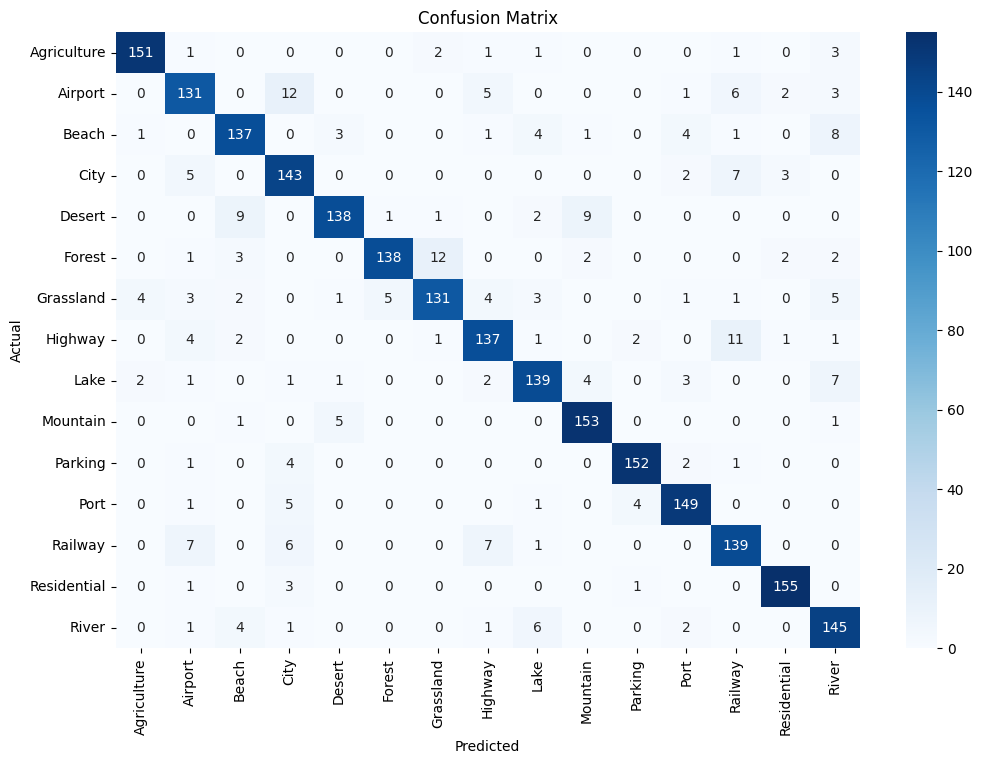

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on test set
loss, acc = model.evaluate(test_loader)
print(f"Test accuracy: {acc:.2f}")

# Predict
preds = model.predict(test_loader)
y_pred = np.argmax(preds, axis=1)
y_true = test_loader.classes
labels = list(test_loader.class_indices.keys())

# Classification report
print(classification_report(y_true, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
from PIL import Image
import os

# Example usage: resize and save an image
image_path = os.path.join(destination_path, '/content/intel-aerial-classification/test/Desert/004.jpg')  # Adjust path
image = Image.open(image_path)

# Resize to 224x224 (common for CNNs)
resized_image = image.resize((224, 224))
resized_image.show()  # or resized_image.save('resized_image.jpg')


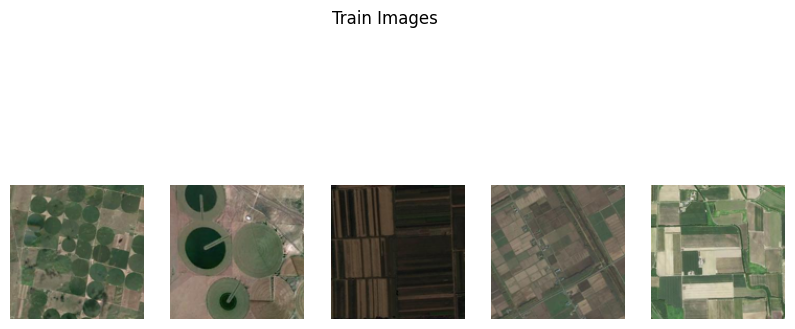

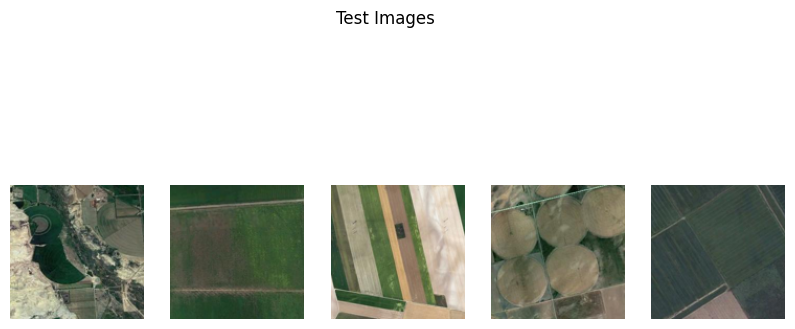

In [ ]:
import matplotlib.pyplot as plt
import glob

# Get sample paths
train_dir = os.path.join(destination_path, 'train')
test_dir = os.path.join(destination_path, 'test')

def show_sample_images(folder, title):
    image_files = glob.glob(os.path.join(folder, '*/*.jpg'))[:5]
    plt.figure(figsize=(10, 5))
    for i, file in enumerate(image_files):
        img = Image.open(file).resize((128, 128))
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_sample_images(train_dir, "Train Images")
show_sample_images(test_dir, "Test Images")


In [ ]:
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [ ]:
import numpy as np
from scipy import stats

# Use your trained model to predict
preds = model.predict(test_loader)
y_pred = np.argmax(preds, axis=1)
y_true = test_loader.classes

# Get per-class accuracy or group metrics
labels = list(test_loader.class_indices.keys())
n_classes = len(labels)

# Example: Split predictions into two groups (first half classes vs second half)
mid = n_classes // 2
group1_classes = list(range(mid))
group2_classes = list(range(mid, n_classes))

group1_indices = np.isin(y_true, group1_classes)
group2_indices = np.isin(y_true, group2_classes)

group1_correct = (y_pred[group1_indices] == y_true[group1_indices])
group2_correct = (y_pred[group2_indices] == y_true[group2_indices])

# Accuracy for each group
group1_acc = group1_correct.mean()
group2_acc = group2_correct.mean()

# Sample sizes
n1 = group1_correct.size
n2 = group2_correct.size

# T-test
t_stat, p_val = stats.ttest_ind(group1_correct.astype(int), group2_correct.astype(int))
print("T-test:", t_stat, p_val)

# Z-test
mean_diff = group1_acc - group2_acc
pooled_se = np.sqrt((group1_acc * (1 - group1_acc)) / n1 + (group2_acc * (1 - group2_acc)) / n2)
z_score = mean_diff / pooled_se
print("Z-test (approx):", z_score)

# ANOVA (here it's just 2 groups, so same as t-test)
f_stat, p_val = stats.f_oneway(group1_correct.astype(int), group2_correct.astype(int))
print("ANOVA:", f_stat, p_val)

# Proportion Z-test
successes = np.array([group1_correct.sum(), group2_correct.sum()])
totals = np.array([n1, n2])

try:
    from scipy import stats
    z_stat, p_val = stats.proportions_ztest(successes, totals)
    print("Proportion Z-test:", z_stat, p_val)
except AttributeError:
    from statsmodels.stats.proportion import proportions_ztest
    z_stat, p_val = proportions_ztest(successes, totals)
    print("Proportion Z-test (using statsmodels):", z_stat, p_val)


75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step
T-test: -3.7795760320699765 0.00016092672625762366
Z-test (approx): -3.733257065624571
ANOVA: 14.285194982197813 0.00016092672625764298
Proportion Z-test (using statsmodels): -3.769939506202883 0.00016328712126506334


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


<ipython-input-25-21b61bc47689>:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


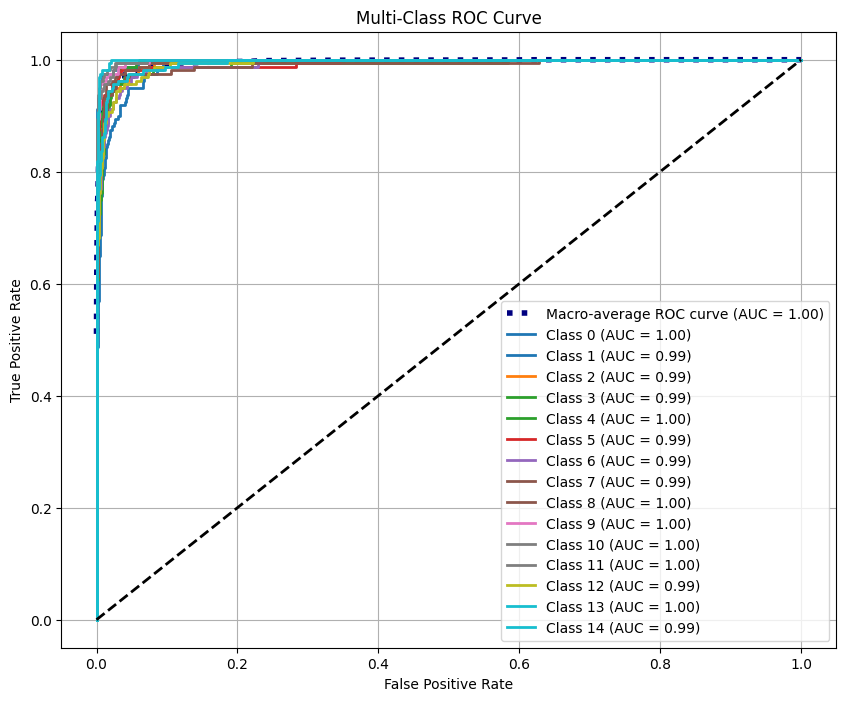

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay

# Get model predictions (probabilities)
preds = model.predict(test_loader)

# True labels
y_true = test_loader.classes

# Classes
class_labels = list(test_loader.class_indices.values())
n_classes = preds.shape[1]

# Binarize the true labels for multi-class ROC
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot macro-average ROC
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"Macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

# Plot per-class ROC
colors = plt.cm.get_cmap('tab10', n_classes)
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors(i),
        lw=2,
        label=f"Class {i} (AUC = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
